In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
import collections
import numpy as np
import pandas as pd
import datetime
import random
import scipy.stats as cov
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [2]:
product_codes = pd.read_excel("problem2/PL_CSA_HNW_2015.xlsx", sheetname="Mnemonic CASA product code")

In [3]:
casa_dec = pd.read_csv("problem2/casa_txn_dec14", sep="|")
casa_jan = pd.read_csv("problem2/casa_txn_jan15", sep="|")
casa_feb = pd.read_csv("problem2/casa_txn_feb15", sep="|")

In [4]:
debit_trans = pd.read_csv("problem2/Debit_card_transaction_data_PL", sep="|")

In [5]:
customers  = pd.read_csv("problem2/Customer_level_data_PL", sep="|")
responder_value_counts = customers["RESPONDER"].value_counts()

In [16]:
def convert_sqrt(values):
    sqrt_vals = []
    for val in values:
        if val < 0:
            sqrt_vals.append(0)
        else:
            sqrt_vals.append(np.sqrt(val))
    return sqrt_vals

In [17]:
customers["net_rel_sqrt"] = convert_sqrt(customers["Net_relationship_value"])
customers["AQB_SQRT"] = convert_sqrt(customers["AQB"])
customers["RATIO_FEB_SQRT"] = convert_sqrt(customers["RATIO_EOP_BAL_FEB15"])

In [172]:
customers["RATIO_FEB_SQRT"].fillna(0, inplace=True)
customers["DEC14_Bal"].fillna(0, inplace=True)
customers["salary_feb15"].fillna(-1, inplace=True)

In [132]:
sum(pd.Series.isnull(customers["RATIO_FEB_SQRT"]))

9743

In [149]:
train_set = customers[customers["Base_tag"]=="D"]
test_set = customers[customers["Base_tag"]=="V"]

In [150]:
train_responders = train_set[train_set["RESPONDER"]==1]
train_non_responders = train_set[train_set["RESPONDER"]==0]

In [91]:
def get_kde_responder(data, col, x):
    kernel = gaussian_kde(data[col].values)
    y = kernel.pdf(x)
    return y

def get_kde_non_responder(data, col, points, rand_iters):
    
    z = np.zeros(len(points))

    for i in range(rand_iters):
        random.seed(i)
        rows = random.sample(data.index, len(train_responders))
        data_sample = data.ix[rows]
        kernel = gaussian_kde(data_sample[col].values)
        y = kernel.pdf(points)
        z = z + y

    z = z/rand_iters
    return z

In [116]:
def transform_feature(data, col, trans_df):
    transformed_vals = []
    vals = data[col]
    for val in vals:
        indices = trans_df.index.values
        if (val < indices[0]) or (val > indices[len(indices)-1]):
            transformed_vals.append(0)
            continue
        
        idx = (np.abs(trans_df.index.values-val)).argmin()
        transformed_vals.append(trans_df.ix[trans_df.index.values[idx]][0])
    
    return transformed_vals

In [152]:
def transform_feature_categorical(data, col, trans_df):
    transformed_vals = []
    vals = data[col]
    for val in vals:
        transformed_vals.append(trans_df.ix[val][0])

    return transformed_vals

In [154]:
def transform_categorical_variable_avg(col):
    col_val_counts = pd.DataFrame(train_responders[col].value_counts())
    col_val_counts = col_val_counts/len(train_responders)
    res_avg_df = pd.DataFrame(col_val_counts)
    
    total_rounds = 10
    not_res_avg_df = pd.DataFrame()
    for i in range(total_rounds):
        random.seed(i)
        rows = random.sample(train_non_responders.index, len(train_responders))
        not_res_sample = train_non_responders.ix[rows]
        col_val_counts = pd.DataFrame(not_res_sample[col].value_counts())
        col_val_counts = col_val_counts/len(train_responders)
        not_res_avg_df = not_res_avg_df.add(col_val_counts, fill_value=0)
    not_res_avg_df = not_res_avg_df/total_rounds
    
    feature_scores = []
    for index in res_avg_df.index:
        feature_score = (2 * res_avg_df.ix[index][0]) - not_res_avg_df.ix[index][0]
        feature_scores.append(feature_score)
    
    feature_df = pd.DataFrame(feature_scores, index=res_avg_df.index)

    return feature_df


In [124]:
aqb_min = 0
aqb_max = customers["AQB_SQRT"].max()
totalpoints = 900
all_points = np.linspace(aqb_min, aqb_max, totalpoints)
aqb_responder_pdf = get_kde_responder(train_responders, "AQB_SQRT", all_points)
aqb_non_responder_pdf = get_kde_non_responder(train_non_responders, "AQB_SQRT", all_points, 20)
aqb_pdf_diff = aqb_responder_pdf - aqb_non_responder_pdf
aqb_pdf_diff = aqb_pdf_diff / np.abs(sum(aqb_pdf_diff))

In [117]:
aqb_pdf_df = pd.DataFrame(aqb_pdf_diff, index=all_points)
transformed_train = pd.DataFrame(train_set["RESPONDER"])
aqb_train_transform = transform_feature(train_set, "AQB_SQRT", aqb_pdf_df)
transformed_train["AQB"] = aqb_train_transform

In [119]:
transformed_test = pd.DataFrame(test_set["RESPONDER"])
aqb_test_transform = transform_feature(test_set, "AQB_SQRT", aqb_pdf_df)
transformed_test["AQB"] = aqb_test_transform

In [173]:
colname = "salary_feb15"
point_min = -1
point_max = customers[colname].max()
totalpoints = 900
all_points = np.linspace(point_min, point_max, totalpoints)

feature_responder_pdf = get_kde_responder(train_responders, colname, all_points)
feature_non_responder_pdf = get_kde_non_responder(train_non_responders, colname, all_points, 20)

feature_pdf_diff = feature_responder_pdf - feature_non_responder_pdf
feature_pdf_diff = feature_pdf_diff / np.abs(sum(feature_pdf_diff))
feature_pdf_df = pd.DataFrame(feature_pdf_diff, index=all_points)

feature_train_transform = transform_feature(train_set, colname, feature_pdf_df)
transformed_train[colname] = feature_train_transform

feature_test_transform = transform_feature(test_set, colname, feature_pdf_df)
transformed_test[colname] = feature_test_transform

ValueError: array must not contain infs or NaNs

In [169]:
colname = "AGE"
feature_imps = transform_categorical_variable_avg(colname)

feature_train_transform = transform_feature_categorical(train_set, colname, feature_imps)
transformed_train[colname] = feature_train_transform

feature_train_transform = transform_feature_categorical(test_set, colname, feature_imps)
transformed_test[colname] = feature_train_transform


KeyError: 21

In [165]:
transformed_train.drop(['net_rel_sqrt','RATIO_FEB_SQRT'], axis=1, inplace=True)
transformed_test.drop(['net_rel_sqrt','RATIO_FEB_SQRT'], axis=1, inplace=True)

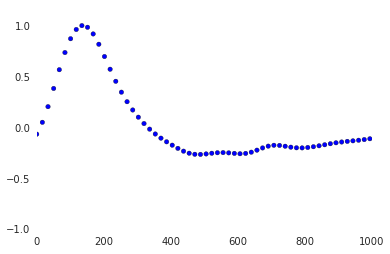

In [95]:
plt.axis([0,1000, -1, 1.2])
plt.scatter(all_points, aqb_pdf_diff)

In [170]:
transformed_train.to_csv("train_all.csv", index=False)
transformed_test.to_csv("test_all.csv", index=False)

In [171]:
transformed_train

,RESPONDER,AQB,CC_SPEND_3M,FEB15_Bal,DEC14_Bal,hnw_segment,PAPQ_Tag,Transactor_revolver_tag,pl_holding,Net_relationship_value_bin,balance_enquiry_bin,OUR_BANK_OTHER_BANK_loan,Event_and_Credit_Card_cash_withd,ratio_eop_amb_bin
0,0,-0.096713,-0.732544,-0.258353,1.083469,0.165673,0.331188,0.071236,0.282002,0.035121,0.111045,0.553596,0.739531,0.084148
2,0,-0.049614,-0.732544,-0.001253,-0.065709,-0.004887,-0.097775,0.071236,0.282002,-0.071355,-0.098093,0.553596,0.739531,0.571355
3,0,0.747279,-0.732544,1.434903,1.083469,-0.004887,0.218355,0.071236,0.282002,0.035121,0.456416,0.553596,0.739531,0.571355
4,0,0.262587,0.309098,1.434903,1.083469,0.839213,0.331188,0.369607,0.282002,-0.071355,0.456416,0.553596,0.739531,0.382638
5,0,0.930637,-0.732544,1.434903,1.083469,0.839213,0.331188,0.071236,0.282002,-0.071355,-0.098093,0.553596,0.739531,0.382638
6,0,-0.240366,0.146599,-0.258353,1.083469,0.165673,0.548232,0.369607,0.282002,-0.071355,0.107747,0.553596,0.260469,0.041756
7,0,-0.255628,-0.732544,-0.258353,1.083469,0.165673,0.331188,0.071236,0.282002,-0.071355,0.114223,0.553596,0.739531,-0.134923
9,0,-0.252124,-0.732544,-0.258353,1.083469,0.165673,-0.097775,0.071236,0.282002,-0.071355,-0.098093,0.553596,0.739531,-0.134923
11,0,-0.175365,0.202640,-0.076064,-0.065709,-0.004887,0.548232,0.369607,0.282002,-0.071355,0.456416,0.553596,0.260469,0.002145
12,0,0.356571,-0.732544,1.434903,1.083469,0.839213,0.331188,0.071236,0.282002,0.228089,0.456416,0.553596,0.260469,0.571355


In [174]:
sum(pd.Series.isnull(customers["salary_feb15"]))

0